# <center>Data Analysis 3 - Assignment 1<center>
    
<center>Created by Zsófia Rebeka Katona</center>


Build four predictive models using linear regression for earnings per hour.
1. Models: the target variable is earnings per hour, all others would be predictors

In [1]:
# Importing the required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [2]:
# Importing the prewritten helper functions
from py_helper_functions import *

In [3]:
# Reading the data
data = pd.read_csv("morg-2014-emp.csv")

# Checking if the data was correctly loaded
data.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149316 entries, 0 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  149316 non-null  int64  
 1   hhid        149316 non-null  int64  
 2   intmonth    149316 non-null  object 
 3   stfips      149316 non-null  object 
 4   weight      149316 non-null  float64
 5   earnwke     149316 non-null  float64
 6   uhours      149316 non-null  int64  
 7   grade92     149316 non-null  int64  
 8   race        149316 non-null  int64  
 9   ethnic      20071 non-null   float64
 10  age         149316 non-null  int64  
 11  sex         149316 non-null  int64  
 12  marital     149316 non-null  int64  
 13  ownchild    149316 non-null  int64  
 14  chldpres    149316 non-null  int64  
 15  prcitshp    149316 non-null  object 
 16  state       149316 non-null  object 
 17  ind02       149316 non-null  object 
 18  occ2012     149316 non-null  int64  
 19  cl

### Exploratory Data Analysis

In [5]:
# Checking the column names to correctly call the variable names
data.columns

Index(['Unnamed: 0', 'hhid', 'intmonth', 'stfips', 'weight', 'earnwke',
       'uhours', 'grade92', 'race', 'ethnic', 'age', 'sex', 'marital',
       'ownchild', 'chldpres', 'prcitshp', 'state', 'ind02', 'occ2012',
       'class', 'unionmme', 'unioncov', 'lfsr94'],
      dtype='object')

In [6]:
# Filtering for Human resource managers (0136) and Human resource workers (630)
data = data[data['occ2012'].isin([136, 630])]
data

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
271,598,992279930309004,January,AK,360.3615,923.00,40,43,1,NaN,...,1,4,"Native, Born In US",94,Support activities for mining (213),136,"Private, For Profit",No,No,Employed-At Work
545,1236,5017808077661,January,CA,3452.5706,1615.38,40,39,1,NaN,...,1,3,"Native, Born In US",93,Executive offices and legislative bodies (9211...,630,Government - Federal,No,No,Employed-At Work
601,1351,65520360020508,January,CA,3457.9806,807.69,40,44,1,1.0,...,0,0,"Native, Born In US",93,"Museums, art galleries, historical sites, and ...",136,"Private, Nonprofit",No,No,Employed-At Work
695,1569,256080630550002,January,CA,2889.1284,807.00,40,44,1,7.0,...,0,0,"Native, Born In US",93,"Museums, art galleries, historical sites, and ...",136,"Private, Nonprofit",No,No,Employed-At Work
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148598,315498,58305630783096,December,WA,3039.5721,600.00,37,39,1,1.0,...,0,0,"Native, Born In US",9,"Other amusement, gambling, and recreation indu...",630,"Private, For Profit",No,No,Employed-At Work
148774,315915,108415040044617,December,WV,673.5209,668.42,38,43,1,NaN,...,0,0,"Native, Born In US",5,Outpatient care centers (6214),136,"Private, For Profit",No,No,Employed-At Work
148827,316049,505181410066,December,WV,539.8396,115.38,50,44,1,NaN,...,0,0,"Native, Born In US",5,"Other schools, instruction, and educational se...",630,"Private, Nonprofit",No,No,Employed-Absent
148943,316329,102506390510951,December,WI,3529.8688,692.40,40,43,1,NaN,...,0,0,"Native, Born In US",3,Computer systems design and related services (...,630,"Private, For Profit",No,No,Employed-At Work


### Creating variables:
- earnings per hour
- log earnings per hour
- female as a dummy variable
- age
- age squared
- level of education (high school education and higher education separately) as a dummy variable
- having children as a dummy variable

In [7]:
# Creating new variables
data["earnphour"] = data["earnwke"] / data["uhours"]
data["lnearnphour"] = np.log(data["earnphour"])
data["female"] = (data["sex"] == 2)
data["agesq"] = np.power(data["age"], 2)
data["edu"] = data["grade92"]
data["children"] = (data["chldpres"].isin([1,2,3,4]).astype(int))

In [8]:
# Grouping educational levels and creating dummies
# 'hsedu' referring to high school education
# "higheredu" referring to higher education, including Bachelors, Masters, PhD and Professional degrees
data["hsedu"] = (data["grade92"] == 39).astype(int)
data["higheredu"] = (data["grade92"].isin([40, 41 ,42 , 43, 44, 45, 46]).astype(int))

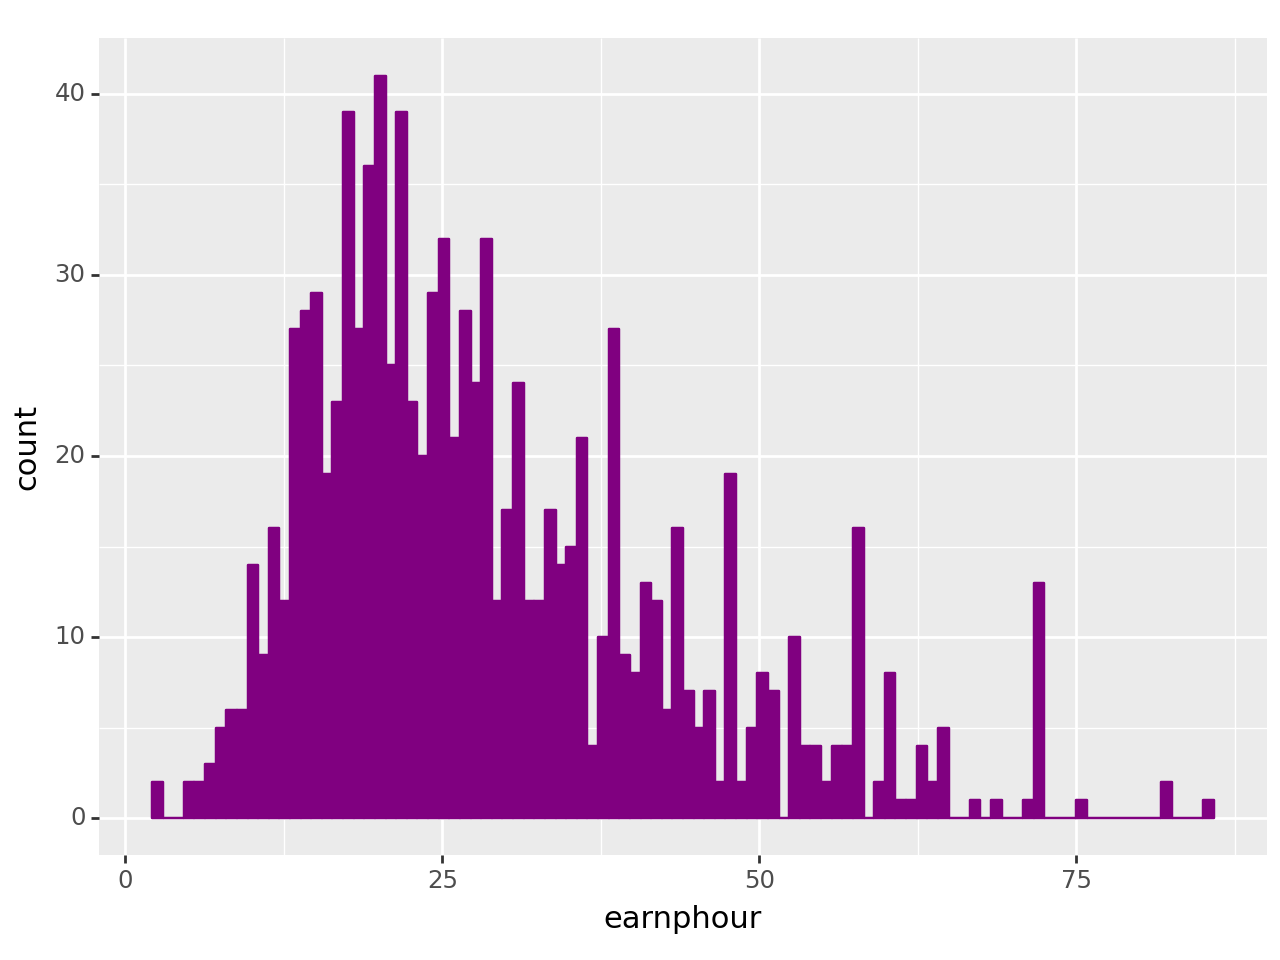

<Figure Size: (640 x 480)>

In [9]:
# Checking for the quality of the distribution and sufficient variation
ggplot(data, aes(x='earnphour')) + geom_histogram(fill='purple', color='purple', bins=100)

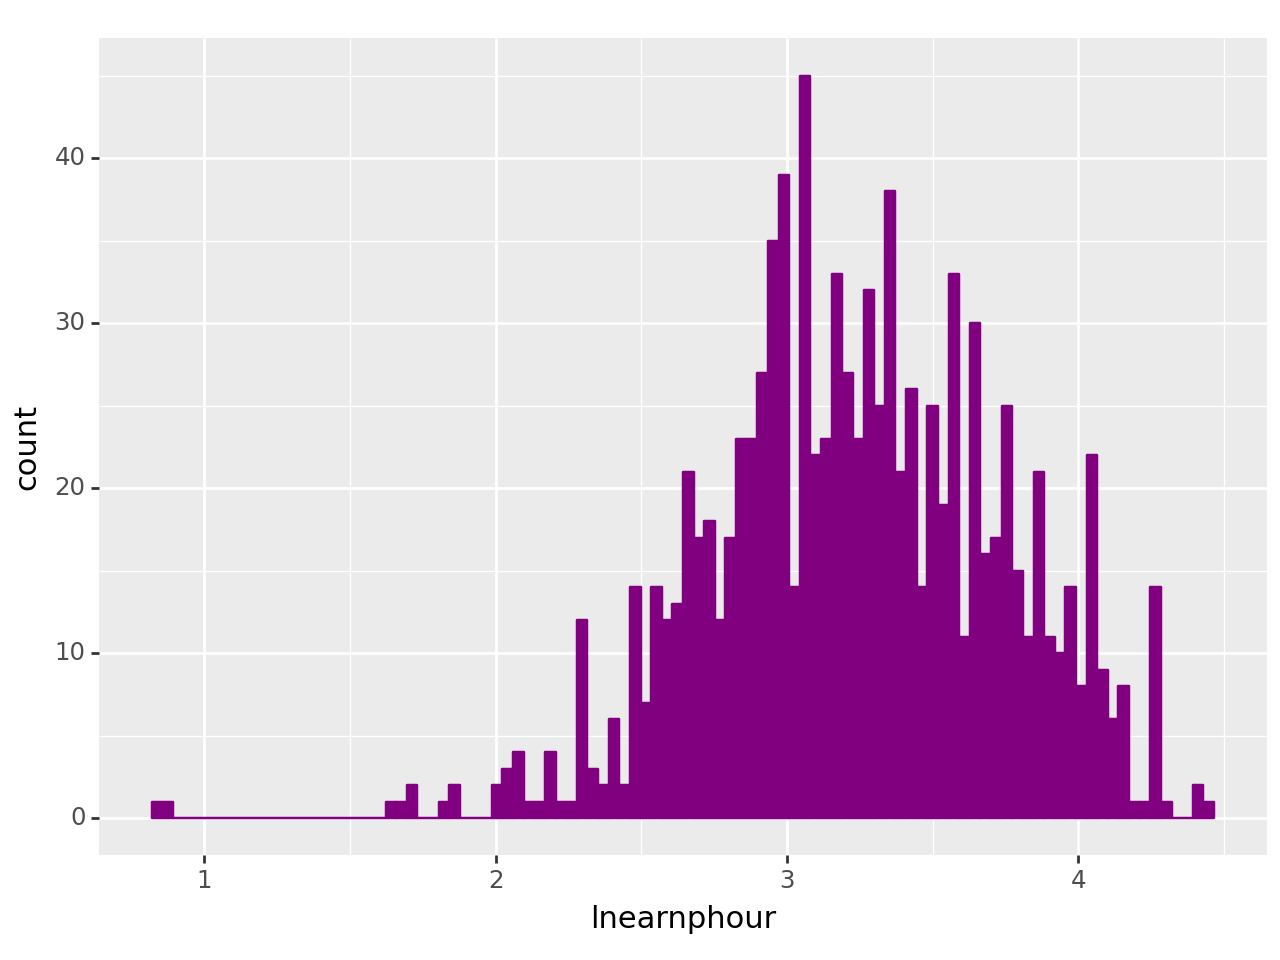

<Figure Size: (640 x 480)>

In [10]:
# Checking the log earnings per hour distribution
ggplot(data, aes(x='lnearnphour')) + geom_histogram(fill='purple', color='purple', bins=100)

In [11]:
# Checking if we have 0 or missing values
data.sort_values(by = 'earnphour')

# There are no values = 0

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,unioncov,lfsr94,earnphour,lnearnphour,female,agesq,edu,children,hsedu,higheredu
148827,316049,505181410066,December,WV,539.8396,115.38,50,44,1,NaN,...,No,Employed-Absent,2.307600,0.836208,False,3364,44,0,0,1
4714,10248,202033508042251,January,LA,3390.3011,96.15,40,44,1,NaN,...,No,Employed-At Work,2.403750,0.877030,False,900,44,0,0,1
36996,78975,126068879100966,April,AL,3400.8182,230.00,45,39,1,NaN,...,No,Employed-At Work,5.111111,1.631417,True,2601,39,0,1,0
89718,190683,502906731999943,August,GA,2870.6039,213.69,40,43,1,1.0,...,No,Employed-At Work,5.342250,1.675647,True,1521,43,1,0,1
31302,66879,803016065908994,March,MT,1024.6256,83.07,15,40,1,NaN,...,No,Employed-At Work,5.538000,1.711633,False,441,40,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144685,307293,196090160000301,December,NY,3191.0810,2884.61,40,44,1,NaN,...,No,Employed-At Work,72.115250,4.278266,True,3721,44,0,0,1
133206,282636,43059686300841,November,OH,2733.3221,1200.00,16,43,1,NaN,...,No,Employed-At Work,75.000000,4.317488,True,3969,43,0,0,1
56830,121226,396947702067673,May,NY,2759.8090,2884.61,35,44,2,NaN,...,No,Employed-At Work,82.417429,4.411797,True,1369,44,1,0,1
30576,65402,450974079025329,March,MN,1767.7635,2307.69,28,45,1,NaN,...,No,Employed-At Work,82.417500,4.411798,True,2809,45,0,0,1


In [71]:
# Checking for NaN in the 'earnphour' column
data.loc[data["earnphour"].isna()]

# There are no missing values

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,unioncov,lfsr94,earnphour,lnearnphour,female,agesq,edu,children,hsedu,higheredu


#### Model 1. - Regression of earnings per hour on age

In [13]:
# Creating the regression and checking the summary of regression
reg1 = smf.ols(formula="earnphour~age", data=data).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              earnphour   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     65.41
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           1.73e-15
Time:                        13:08:00   Log-Likelihood:                -4123.8
No. Observations:                1017   AIC:                             8252.
Df Residuals:                    1015   BIC:                             8261.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2514      1.508     10.777      0.000      13.296      19.207
age            0.2989      0.037      8.087      0.000       0.226       0.371
==============================================================================
Omnibus:                      130.536   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.444
Skew:                           0.970   Prob(JB):                     3.98e-40
Kurtosis:                       3.721   Cond. No.                         167.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

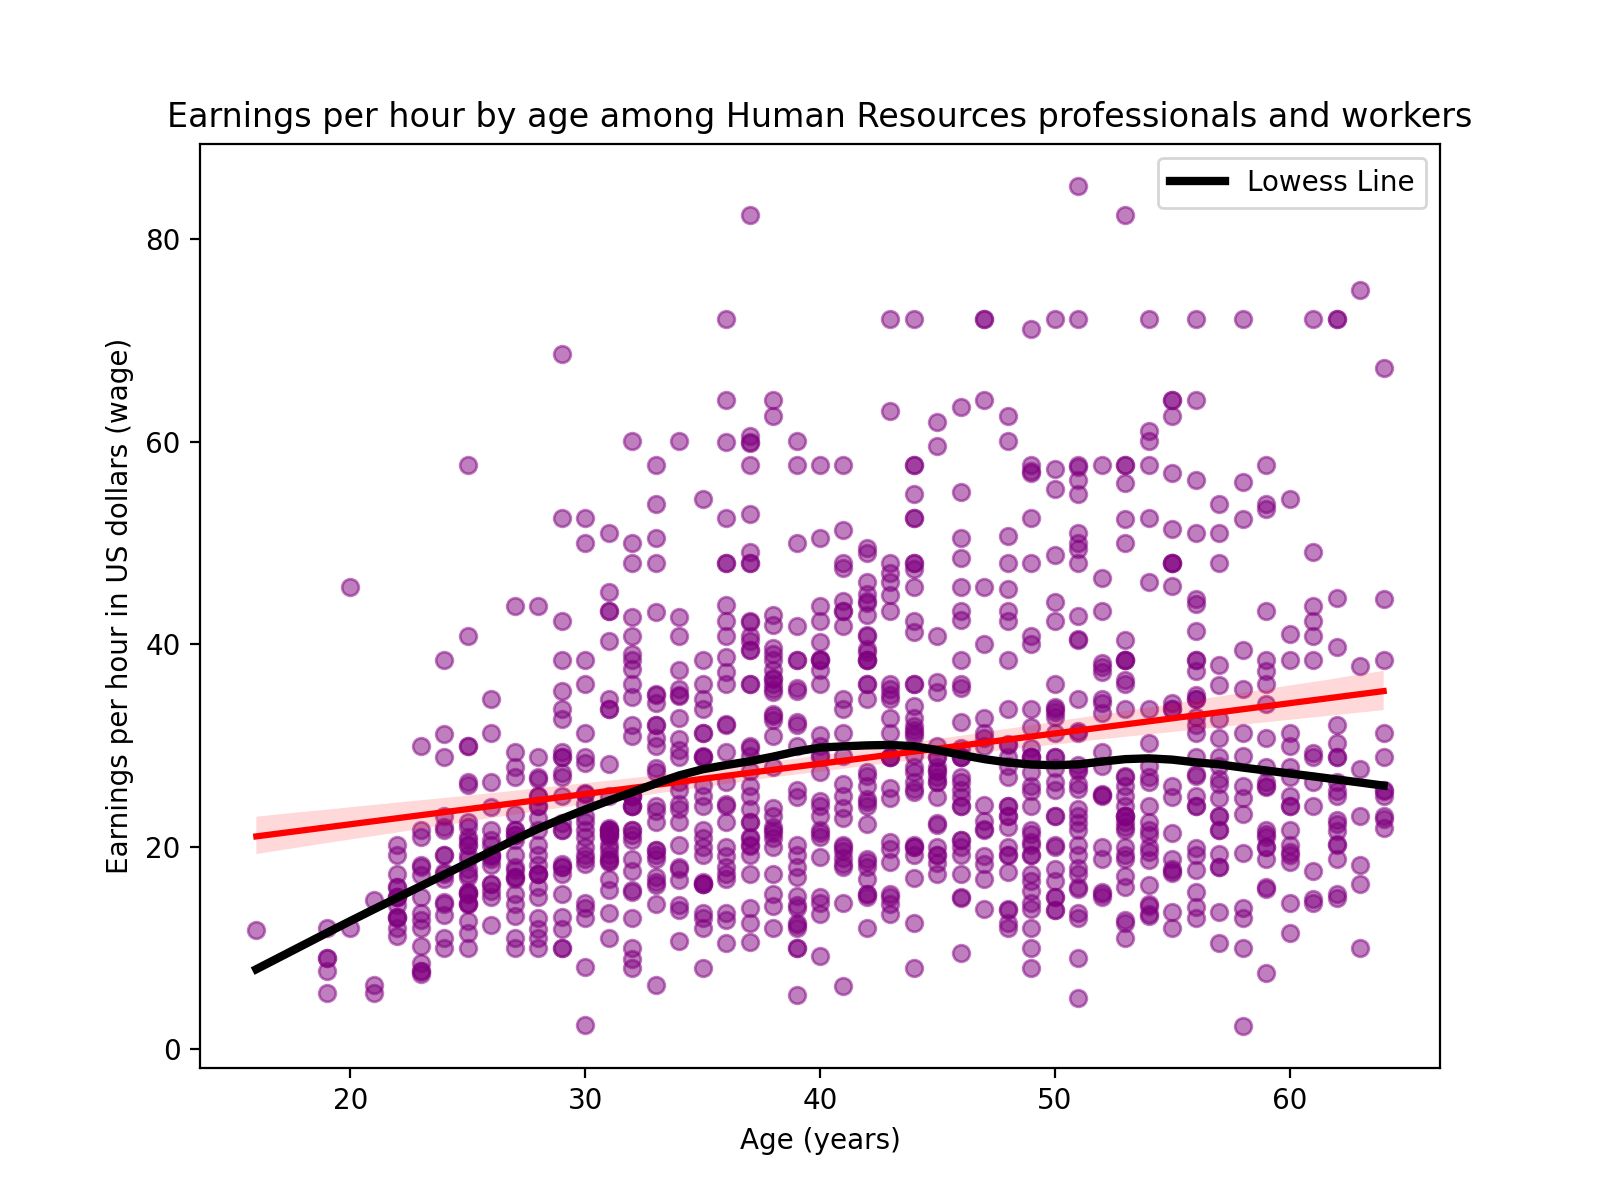

In [83]:
# Creating the scatter plot with the regression line (model 1) and lowess method
plt.figure(figsize=(8, 6))
sns.regplot(x=data['age'], y=data['earnphour'], scatter_kws={'alpha': 0.5, 'color': 'purple'}, line_kws={'color': 'red'})

# Calculating lowess values
lowess = sm.nonparametric.lowess(data['earnphour'], data['age'], frac=0.3)

# Plotting the lowess line
plt.plot(lowess[:, 0], lowess[:, 1], color='black', label='Lowess Line', linewidth=3)

# Customizing the titles and labels
plt.title("Earnings per hour by age among Human Resources professionals and workers")
plt.xlabel('Age (years)')
plt.ylabel('Earnings per hour in US dollars (wage)')
plt.legend()

plt.show()

In [73]:
# Regression summary with HC1 type of robust error in another summary form
print(reg1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:              earnphour   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     65.41
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           1.73e-15
Time:                        17:01:06   Log-Likelihood:                -4123.8
No. Observations:                1017   AIC:                             8252.
Df Residuals:                    1015   BIC:                             8261.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2514      1.508     10.777      0.0

#### Model 2.: Expanding the model by adding the age squared variable

In [16]:
# Creating regression for Model 2
reg2 = smf.ols(formula="earnphour~age + agesq", data=data).fit(cov_type="HC1")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              earnphour   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     85.17
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           6.41e-35
Time:                        13:08:01   Log-Likelihood:                -4103.1
No. Observations:                1017   AIC:                             8212.
Df Residuals:                    1014   BIC:                             8227.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.4187      4.854     -4.001      0.000     -28.932      -9.905
age            2.1236      0.256      8.283      0.000       1.621       2.626
agesq         -0.0216      0.003     -6.885      0.000      -0.028      -0.015
==============================================================================
Omnibus:                      134.659   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.153
Skew:                           0.965   Prob(JB):                     1.88e-42
Kurtosis:                       3.902   Cond. No.                     2.86e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
# Comparing the first two regressions with stargazer
sg = stargazer.Stargazer([reg1, reg2])
sg.covariate_order(["age", "agesq", "Intercept"])
sg.rename_covariates({"Intercept": "Constant"})
sg

#### Model 3. Expanding the model by adding the female dummy variable

In [18]:
# Creating the regression of Model 3
reg3 = smf.ols(formula="earnphour~age + agesq + female", data=data).fit(cov_type="HC1")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              earnphour   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     66.62
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           2.56e-39
Time:                        13:08:01   Log-Likelihood:                -4090.5
No. Observations:                1017   AIC:                             8189.
Df Residuals:                    1013   BIC:                             8209.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -16.6569      4.946     -3.368      0.001     -26.351      -6.963
female[T.True]    -4.9197      1.022     -4.813      0.000      -6.923      -2.916
age                2.1718      0.256      8.472      0.000       1.669       2.674
agesq             -0.0222      0.003     -7.093      0.000      -0.028      -0.016
==============================================================================
Omnibus:                      135.999   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.864
Skew:                           0.954   Prob(JB):                     1.08e-43
Kurtosis:                       4.014   Cond. No.                     2.88e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 4: Expanding the last model by adding the high school education, higher education and children dummy variables

In [19]:
# Creating the regression of Model 4
reg4 = smf.ols(formula="earnphour~age + agesq + female + hsedu + higheredu + children", data=data).fit(cov_type="HC1")
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              earnphour   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     35.30
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           6.96e-39
Time:                        13:08:01   Log-Likelihood:                -4075.3
No. Observations:                1017   AIC:                             8165.
Df Residuals:                    1010   BIC:                             8199.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -26.9408      6.082     -4.429      0.000     -38.862     -15.019
female[T.True]    -4.7236      1.013     -4.665      0.000      -6.708      -2.739
age                1.9880      0.269      7.398      0.000       1.461       2.515
agesq             -0.0197      0.003     -6.031      0.000      -0.026      -0.013
hsedu              7.8498      2.851      2.754      0.006       2.263      13.437
higheredu         13.4779      2.691      5.008      0.000       8.203      18.753
children           1.6197      1.024      1.582      0.114      -0.386       3.626
==============================================================================
Omnibus:                      136.514   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.039
Skew:                           0.951   Prob(JB):                     3.65e-44
Kurtosis:                       4.049   Cond. No.                     4.41e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Summarizing the regression results with HC1 robust standard error
models = [reg1, reg2, reg3, reg4]
robustcov_results=[]

for i, model in enumerate(models):
    result=model.get_robustcov_results(cov_type='HC1').summary()
    robustcov_results.append(result)
    print()
    print(f'Regression: reg{i+1}')
    print(result)


Regression: reg1
                            OLS Regression Results                            
Dep. Variable:              earnphour   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     65.41
Date:                Sun, 21 Jan 2024   Prob (F-statistic):           1.73e-15
Time:                        13:08:01   Log-Likelihood:                -4123.8
No. Observations:                1017   AIC:                             8252.
Df Residuals:                    1015   BIC:                             8261.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.2514      1.508  

### BIC evaluation criteria

In [78]:
# Comparing the regressions in stargazer and adding the BIC scores for comparison

# Calculating the BIC scores
bic = [round(x.bic, 2) for x in [reg1,reg2,reg3,reg4]]

# Calling stargazer
sg = stargazer.Stargazer([reg1,reg2,reg3,reg4])
sg.covariate_order(["age", "agesq", "female[T.True]", "hsedu", "higheredu", "children", "Intercept"])
sg.rename_covariates({"Intercept": "Constant"})

# Adding the BIC scores as a separate line
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

In [22]:
# Checking the BIC of regression 1 (Model 1)
reg1.bic

8261.36659625481

In [23]:
# Checking the BIC of regression 2 (Model 2)
reg2.bic

8227.030747662391

In [24]:
# Checking the BIC of regression 3 (Model 3)
reg3.bic

8208.75877906075

In [25]:
# Checking the BIC of regression 4 (Model 4)
reg4.bic

8199.06489734849

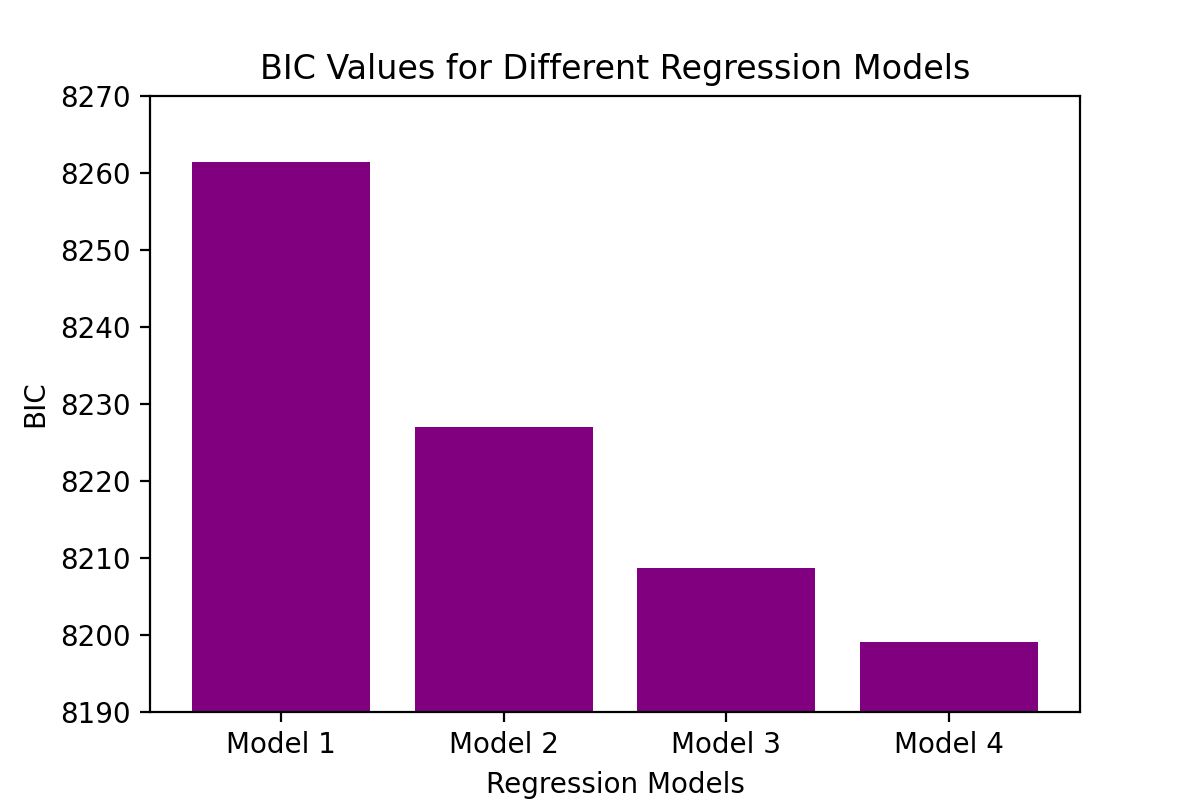

In [81]:
# Plotting a bar chart to visualize the differences in BIC scores
bic_values = [8261.37, 8227.03, 8208.76, 8199.06]

# Model names as labels
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Customizing the bar chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, bic_values, color='purple')

# Adjusting and giving a limited interval for the y axis to see the slight differences between the scores
plt.ylim(8190, 8270)
plt.title('BIC Values for Different Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('BIC')
plt.show()

Indirect evaluation: Model 4 has the lowest BIC score, suggesting the least overfitting and the best fit and penalty.

### RMSE in the full sample

In [26]:
# Getting the root squared mean error (RMSE) of Model 1
rmse(reg1.fittedvalues,data.earnphour)

13.955701016022353

In [27]:
# Getting the root squared mean error (RMSE) of Model 2
rmse(reg2.fittedvalues,data.earnphour)

13.675456375291205

In [28]:
# Getting the root squared mean error (RMSE) of Model 3
rmse(reg3.fittedvalues,data.earnphour)

13.507093894664019

In [29]:
# Getting the root squared mean error (RMSE) of Model 4
rmse(reg4.fittedvalues,data.earnphour)

13.306276061893485

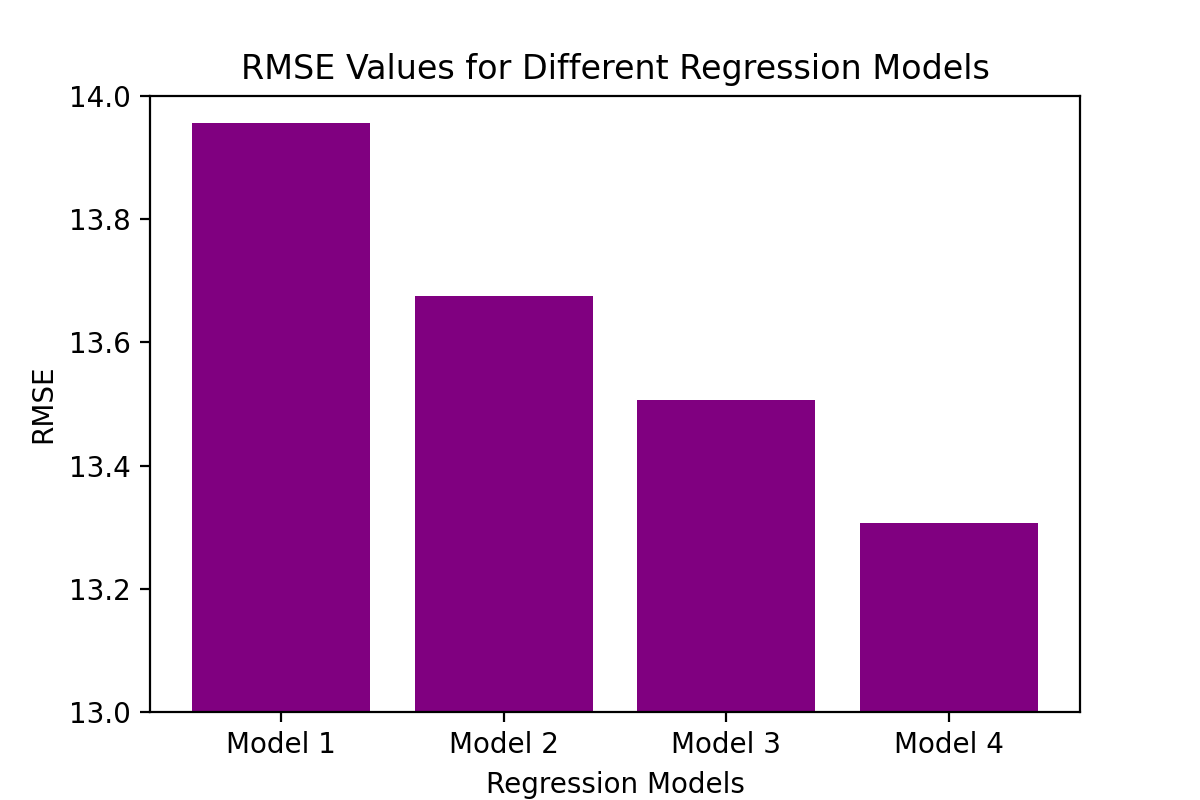

In [67]:
# Plotting a bar chart to visualize the differences in RMSE scores
rmse_values = [rmse(reg1.fittedvalues, data.earnphour),
               rmse(reg2.fittedvalues, data.earnphour),
               rmse(reg3.fittedvalues, data.earnphour),
               rmse(reg4.fittedvalues, data.earnphour)]

# Model names as labels
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Customizing the bar chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, rmse_values, color='purple')

# Adjusting and giving a limited interval for the y axis to see the slight differences between the scores
plt.ylim(13, 14)
plt.title('RMSE Values for Different Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('RMSE')
plt.show()

It can be concluded that Model 4 has the lowest RMSE for the target observations and can provide the best prediction.

### Cross-validated RMSE

In [30]:
# Importing the package for cross-validation
from sklearn.model_selection import KFold

# Splitting the data into 4 categories, assuming that the data is randomly ordered
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [31]:
# Defining the cross-validation 
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [32]:
# Performing cross-validated linear regressions without heteroskedastic robust error (cov.type = HC0)
cv1 = cv_reg("earnphour~age", data, k, "HC0")
cv2 = cv_reg("earnphour~age + agesq", data, k, "HC0")
cv3 = cv_reg("earnphour~age + agesq + female", data, k, "HC0")
cv4 = cv_reg("earnphour~age + agesq + female + higheredu", data, k, "HC0")

cv_list = [cv1, cv2, cv3, cv4]

In [33]:
# Cross-validation summary table
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,13.953777,13.741584,13.556274,13.339585
Fold2,14.024023,13.756001,13.572651,13.442045
Fold3,14.104523,13.830002,13.650977,13.520041
Fold4,13.731938,13.352327,13.225256,13.034297
Average,13.953565,13.669979,13.501289,13.333992


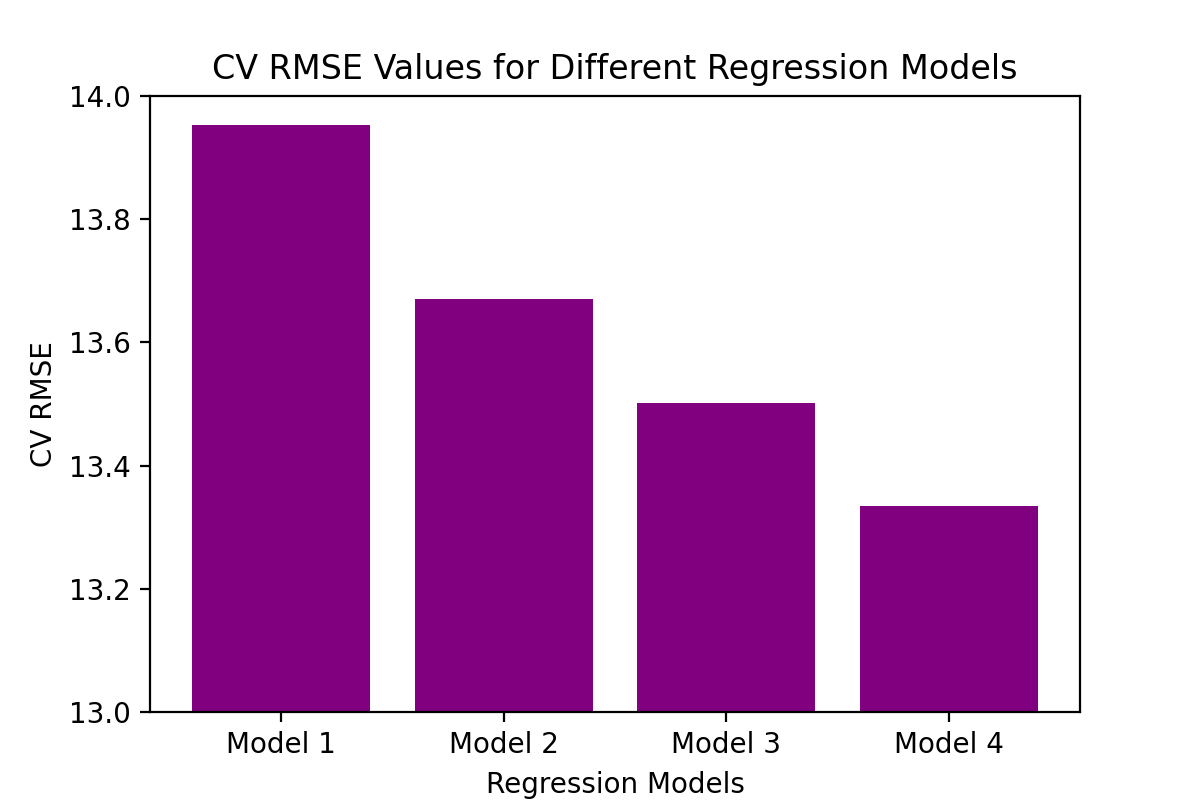

In [68]:
# Plotting a bar chart to visualize the differences in CV RMSE scores
rmse_values = [13.953565, 13.669979, 13.501289, 13.333992]

# Model names or labels
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Customizing the bar chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, rmse_values, color='purple')

# Adjusting and giving a limited interval for the y axis to see the slight differences between the scores
plt.ylim(13, 14)
plt.title('CV RMSE Values for Different Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('CV RMSE')
plt.show()

According to the cross-validated RMSE models, we can conclude that Model 4 still provides the best fit.

### Prediction

In [34]:
# Checking the data types of the data to carry out the correct prediction
data.dtypes

Unnamed: 0       int64
hhid             int64
intmonth        object
stfips          object
weight         float64
earnwke        float64
uhours           int64
grade92          int64
race             int64
ethnic         float64
age              int64
sex              int64
marital          int64
ownchild         int64
chldpres         int64
prcitshp        object
state           object
ind02           object
occ2012          int64
class           object
unionmme        object
unioncov        object
lfsr94          object
earnphour      float64
lnearnphour    float64
female            bool
agesq            int64
edu              int64
children         int32
hsedu            int32
higheredu        int32
dtype: object

In [35]:
data.earnphour.describe()

count    1017.000000
mean       28.846571
std        14.372097
min         2.307600
25%        18.511111
50%        25.225000
75%        36.250000
max        85.256333
Name: earnphour, dtype: float64

In [36]:
# Mapping the female variable from boolean to numeric dtype to carry out the prediction
data["female"] = data["female"].astype(int)
data

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,unioncov,lfsr94,earnphour,lnearnphour,female,agesq,edu,children,hsedu,higheredu
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,No,Employed-At Work,42.300000,3.744787,1,841,43,0,0,1
271,598,992279930309004,January,AK,360.3615,923.00,40,43,1,NaN,...,No,Employed-At Work,23.075000,3.138750,1,2500,43,1,0,1
545,1236,5017808077661,January,CA,3452.5706,1615.38,40,39,1,NaN,...,No,Employed-At Work,40.384500,3.698446,1,2601,39,1,1,0
601,1351,65520360020508,January,CA,3457.9806,807.69,40,44,1,1.0,...,No,Employed-At Work,20.192250,3.005299,1,784,44,0,0,1
695,1569,256080630550002,January,CA,2889.1284,807.00,40,44,1,7.0,...,No,Employed-At Work,20.175000,3.004444,1,961,44,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148598,315498,58305630783096,December,WA,3039.5721,600.00,37,39,1,1.0,...,No,Employed-At Work,16.216216,2.786012,1,1089,39,0,1,0
148774,315915,108415040044617,December,WV,673.5209,668.42,38,43,1,NaN,...,No,Employed-At Work,17.590000,2.867331,1,3025,43,0,0,1
148827,316049,505181410066,December,WV,539.8396,115.38,50,44,1,NaN,...,No,Employed-Absent,2.307600,0.836208,0,3364,44,0,0,1
148943,316329,102506390510951,December,WI,3529.8688,692.40,40,43,1,NaN,...,No,Employed-At Work,17.310000,2.851284,1,784,43,0,0,1


In [37]:
# Choosing values for our prediction variables
new = pd.DataFrame(pd.Series({
    "earnphour" : 28, 
    "age":30,
    "agesq":30**2,
    "female" : 1,
    "hsedu" : 1,
    "higheredu" : 1,
    "children" : 0
})).T
new

,earnphour,age,agesq,female,hsedu,higheredu,children
0,28,30,900,1,1,1,0


In [38]:
# Turning off scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [39]:
# Checking the residual values for Model 1
reg1.resid.describe()

count   1017.000
mean       0.000
std       13.963
min      -31.278
25%       -9.898
50%       -3.531
75%        7.864
max       55.108
dtype: float64

In [40]:
# Getting the basic metrics of fitted values
(reg1.fittedvalues-data.earnphour).describe()

count   1017.000
mean      -0.000
std       13.963
min      -55.108
25%       -7.864
50%        3.531
75%        9.898
max       31.278
dtype: float64

In [41]:
# Getting the predictions using regression 1 and extracting its summary statistics
p1=reg1.get_prediction(new).summary_frame()
p1

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,25.218,0.543,24.154,26.281,-2.183,52.618


In [42]:
# Checking the residual values for Model 2
reg2.resid.describe()

count   1017.000
mean       0.000
std       13.682
min      -28.667
25%       -9.601
50%       -2.888
75%        7.224
max       52.879
dtype: float64

In [43]:
# Getting the basic metrics of fitted values
(reg2.fittedvalues-data.earnphour).describe()

count   1017.000
mean      -0.000
std       13.682
min      -52.879
25%       -7.224
50%        2.888
75%        9.601
max       28.667
dtype: float64

In [44]:
# Getting the predictions using regression 2 and extracting its summary statistics
p2=reg2.get_prediction(new).summary_frame()
p2

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.819,0.492,23.854,25.784,-2.041,51.680


In [45]:
# Checking the residual values for Model 3
reg3.resid.describe()

count   1017.000
mean       0.000
std       13.514
min      -32.246
25%       -9.301
50%       -2.634
75%        6.436
max       54.060
dtype: float64

In [46]:
# Getting the basic metrics of fitted values
(reg3.fittedvalues-data.earnphour).describe()

count   1017.000
mean      -0.000
std       13.514
min      -54.060
25%       -6.436
50%        2.634
75%        9.301
max       32.246
dtype: float64

In [47]:
# Getting the predictions using regression 3 and extracting its summary statistics
p3=reg3.get_prediction(new).summary_frame()
p3

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,23.577,0.533,22.533,24.621,-2.969,50.123


In [48]:
# Checking the residual values for Model 4
reg4.resid.describe()

count   1017.000
mean       0.000
std       13.313
min      -33.276
25%       -9.039
50%       -2.543
75%        6.293
max       52.392
dtype: float64

In [49]:
# Getting the basic metrics of fitted values
(reg4.fittedvalues-data.earnphour).describe()

count   1017.000
mean      -0.000
std       13.313
min      -52.392
25%       -6.293
50%        2.543
75%        9.039
max       33.276
dtype: float64

In [50]:
# Getting the predictions using regression 4 and extracting its summary statistics
p4=reg4.get_prediction(new).summary_frame()
p4

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,31.577,2.900,25.894,37.261,4.797,58.357


In [51]:
# Summary of the predictions with 80% prediction intervals
p1=reg1.get_prediction(new).summary_frame(alpha=0.2)
p2=reg2.get_prediction(new).summary_frame(alpha=0.2)
p3=reg3.get_prediction(new).summary_frame(alpha=0.2)
p4=reg4.get_prediction(new).summary_frame(alpha=0.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0]
    }
).set_index(" ")

,Model1,Model2,Model3,Model4
,,,,
Predicted,25.218,24.819,23.577,31.577
PI_low(80%),7.301,7.256,6.220,14.067
PI_high(80%),43.134,42.382,40.935,49.088


Based on the 80% confidence interval, it can be concluded that even with the best model selection, Model 4 CI's is extremely wide, suggesting that our target variable's predicted earnings per hour/wage falls between 14 and 49, which is still large.

In [52]:
# Creating a DataFrame for the predicted values and the 95% prediciton intervals 
pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p1[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model2": p2[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p3[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model4": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0]
    }
).set_index(" ")

,Model1,Model2,Model3,Model4
,,,,
Predicted,25.218,24.819,23.577,31.577
PI_low(95%),7.301,7.256,6.220,14.067
PI_high(95%),43.134,42.382,40.935,49.088
